C=1, w=[-0.26828559  0.48442463  1.38689157 -0.34489066  0.57312161  0.83120292
  0.11165774  0.75984844]


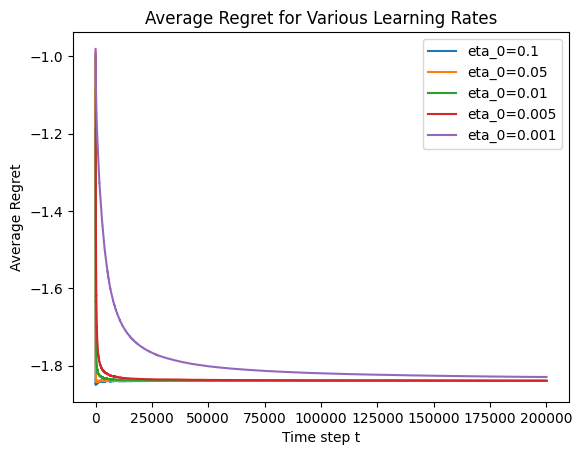

C=11, w=[-0.36873488  0.43122996  1.51203312 -0.25671216  0.65024027  0.82168739
  0.17624018  0.83172666]


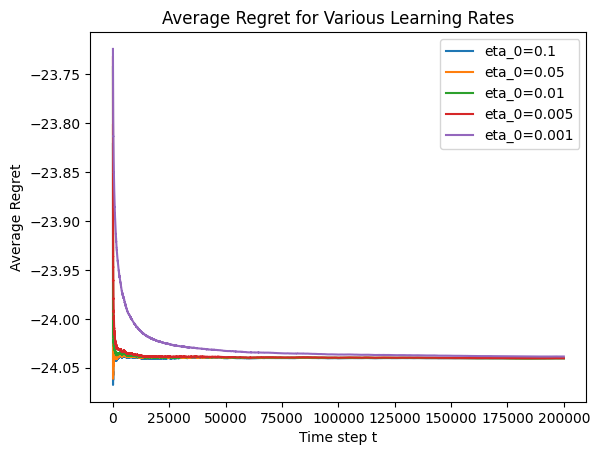

C=21, w=[-0.36873488  0.43122996  1.51203312 -0.25671216  0.65024027  0.82168739
  0.17624018  0.83172666]


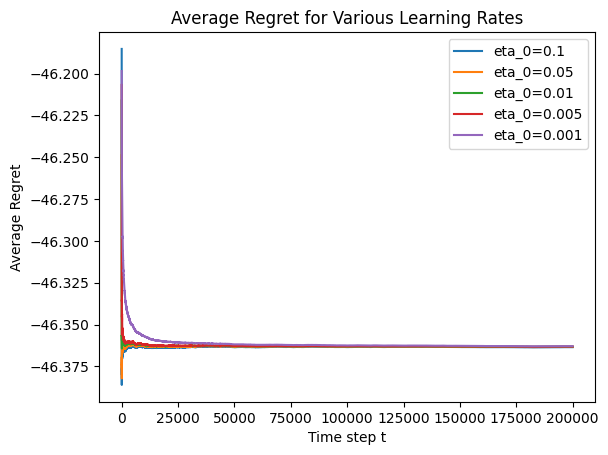

C=31, w=[-0.36873488  0.43122996  1.51203312 -0.25671216  0.65024027  0.82168739
  0.17624018  0.83172666]


KeyboardInterrupt: 

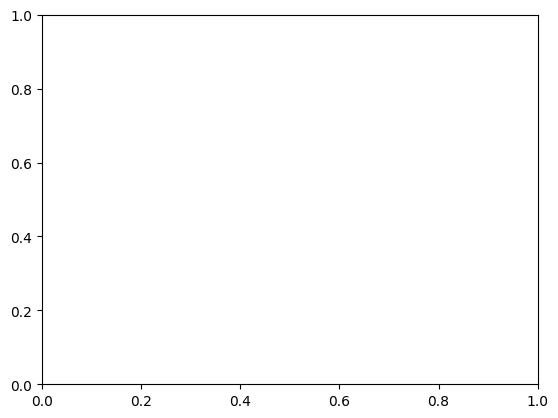

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load the dataset
def load_dataset_small(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y


# Function to compute hinge loss with L2 regularization
def hinge_loss(w, x, y, lambda_reg):
    # Regular hinge loss plus L2 regularization term
    return max(0, 1 - y * np.dot(w, x)) + (lambda_reg / 2) * np.linalg.norm(w)**2

# Function to compute the gradient of hinge loss with L2 regularization
def hinge_loss_gradient(w, x, y, lambda_reg):
    if y * np.dot(w, x) < 1:
        return -y * x + lambda_reg * w
    else:
        return lambda_reg * w

# Project onto the feasible set S (optional depending on how strong you want regularization to be)
def project(w):
    norm = np.linalg.norm(w)
    if norm > 1:
        w = w / norm
    return w

# Online SVM using SGD with regularization
def online_svm(X, y, eta_0, lambda_reg, epochs=1):
    n_features = X.shape[1]
    w = np.zeros(n_features)
    regrets = []

    for epoch in range(epochs):
        for t, (x_t, y_t) in enumerate(zip(X, y)):
            eta_t = eta_0 * (1 / np.sqrt(t + 1))
            w -= eta_t * hinge_loss_gradient(w, x_t, y_t, lambda_reg)
            w = project(w)  # Still project if you want to strictly limit the norm of w
            w_star = svc.coef_[0]  # Using pre-trained batch SVM as w*
            lt_wt = hinge_loss(w, x_t, y_t, lambda_reg)
            lt_wstar = hinge_loss(w_star, x_t, y_t, lambda_reg)
            regrets.append(lt_wt - lt_wstar)

    average_regrets = np.cumsum(regrets) / np.arange(1, len(regrets)+1)
    return w, average_regrets

#X,y = load_dataset_small('toydata_tiny.csv')
X,y = load_dataset_small('toydata_large.csv')
# Train a batch SVM to estimate the optimal w*

for c in range(1, 100, 10):
    svc = SVC(kernel='linear', C=c)
    svc.fit(X, y)
    print(f"C={c}, w={svc.coef_[0]}")

    # Initial learning rates to test
    initial_learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
    epochs = 1  # For simplicity, run only 1 epoch

    fig, ax = plt.subplots()
    for eta_0 in initial_learning_rates:
        _, average_regrets = online_svm(X, y, eta_0,c, epochs)
        ax.plot(average_regrets, label=f'eta_0={eta_0}')

    ax.set_xlabel('Time step t')
    ax.set_ylabel('Average Regret')
    ax.legend()
    ax.set_title('Average Regret for Various Learning Rates')
    plt.show()


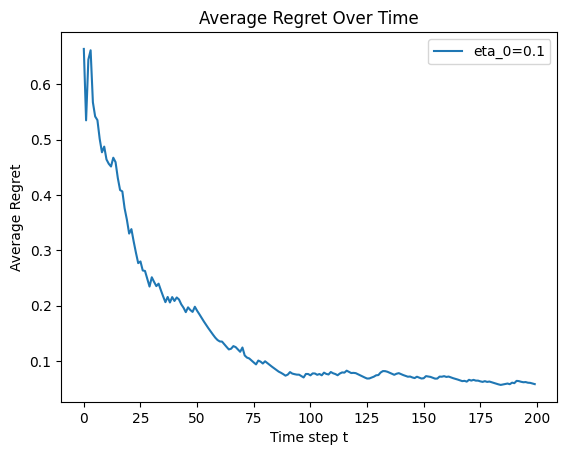

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load and preprocess the dataset
def load_dataset_small(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

# Function to compute hinge loss with L2 regularization
def hinge_loss(w, x, y, lambda_reg):
    return max(0, 1 - y * np.dot(w, x)) + (lambda_reg / 2) * np.linalg.norm(w)**2

# Function to compute the gradient of hinge loss with L2 regularization
def hinge_loss_gradient(w, x, y, lambda_reg):
    if y * np.dot(w, x) < 1:
        return -y * x + lambda_reg * w
    else:
        return lambda_reg * w

# Optional projection to limit the norm of w
def project(w):
    norm = np.linalg.norm(w)
    if norm > 1:
        w = w / norm
    return w

# Online SVM with regularization
def online_svm(X, y, eta_0, lambda_reg, epochs=1):
    n_features = X.shape[1]
    w = np.zeros(n_features)
    regrets = []

    for epoch in range(epochs):
        for t, (x_t, y_t) in enumerate(zip(X, y)):
            eta_t = eta_0 * (1 / np.sqrt(t + 1))
            w -= eta_t * hinge_loss_gradient(w, x_t, y_t, lambda_reg)
            w = project(w)
            w_star = svc.coef_[0]
            lt_wt = hinge_loss(w, x_t, y_t, lambda_reg)
            lt_wstar = hinge_loss(w_star, x_t, y_t, lambda_reg)
            regrets.append(lt_wt - lt_wstar)

    average_regrets = np.cumsum(regrets) / np.arange(1, len(regrets)+1)
    return w, average_regrets

# Example dataset loading and model training
X, y = load_dataset_small('toydata_tiny.csv')  # Specify your actual file path
lambda_reg = 0.01  # Consistent regularization strength

# Train a batch SVM to estimate the optimal w* with the same lambda_reg
C_value = 1 / lambda_reg  # Convert lambda to C for sklearn SVM
svc = SVC(kernel='linear', C=C_value)
svc.fit(X, y)

# Train the online SVM and plot regrets
eta_0 = 0.1
epochs = 1
_, average_regrets = online_svm(X, y, eta_0, lambda_reg, epochs)

# Plotting
plt.plot(average_regrets, label=f'eta_0={eta_0}')
plt.xlabel('Time step t')
plt.ylabel('Average Regret')
plt.legend()
plt.title('Average Regret Over Time')
plt.show()


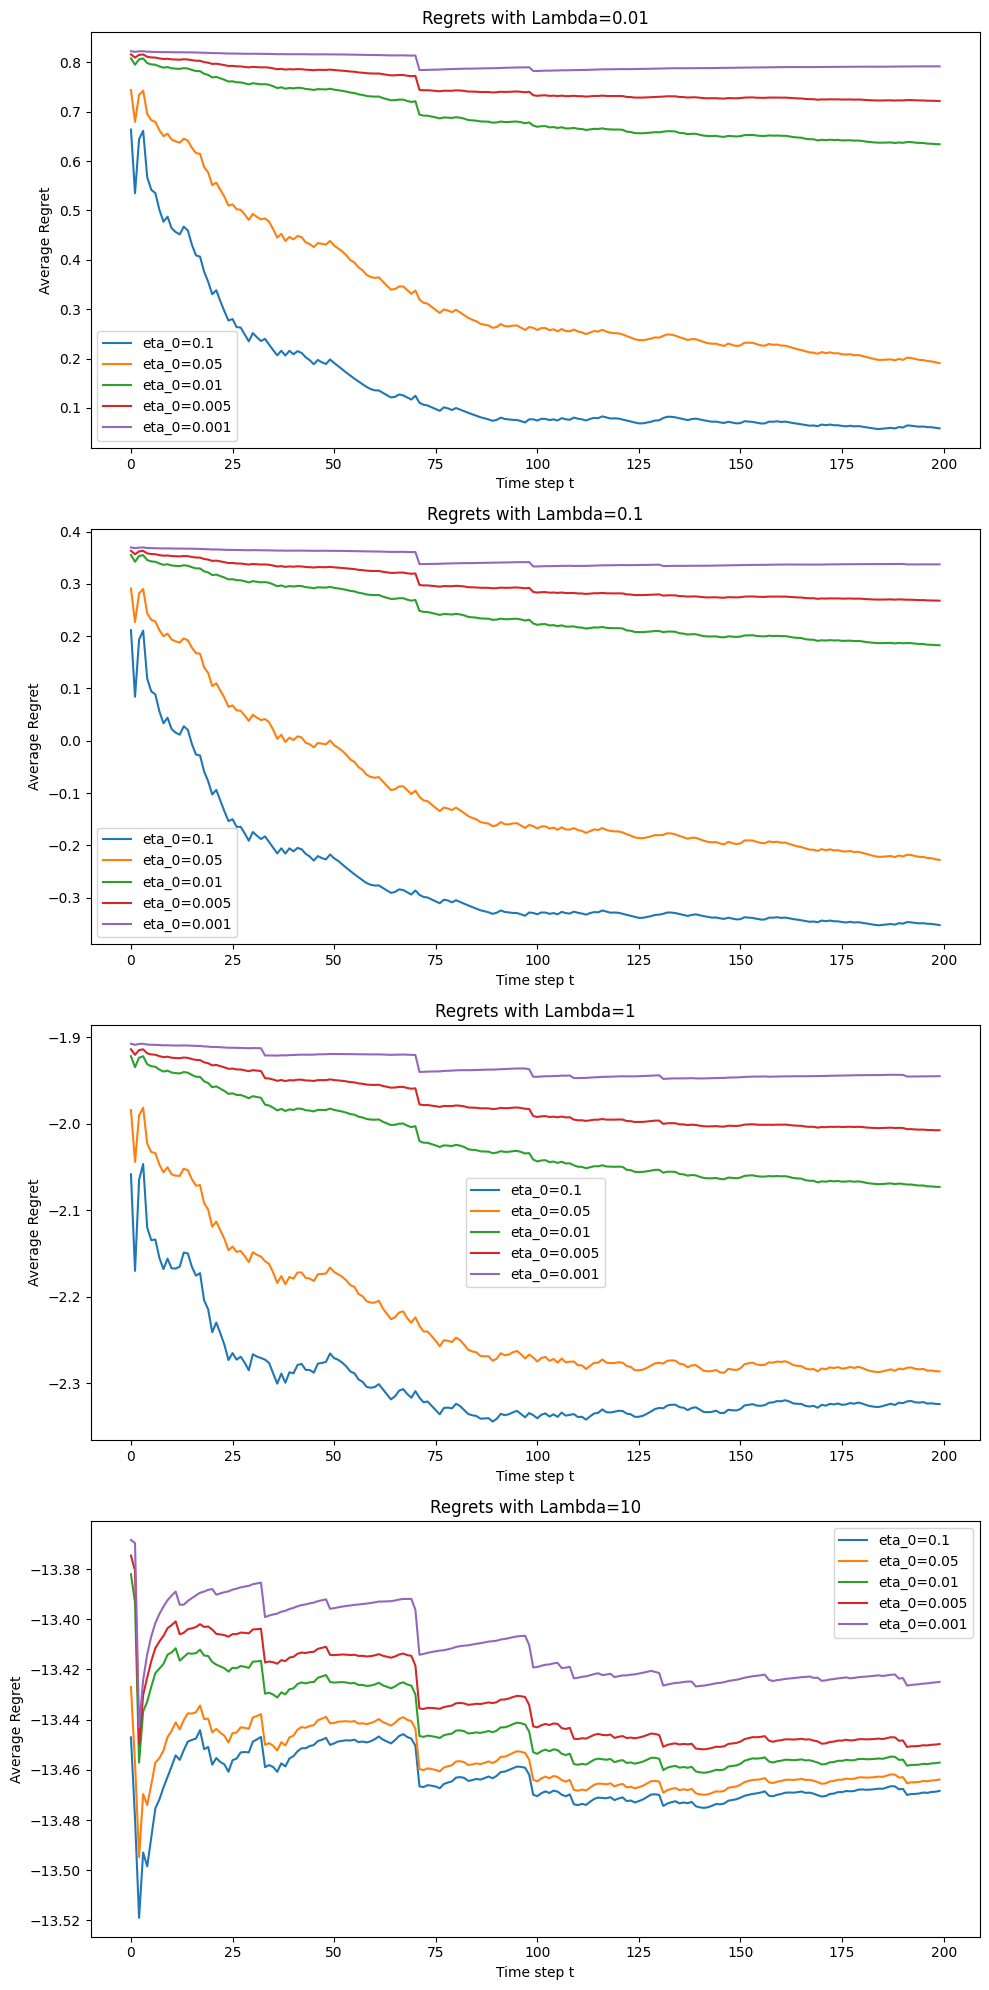

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load and preprocess the dataset
def load_dataset_small(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

# Function to compute hinge loss with L2 regularization
def hinge_loss(w, x, y, lambda_reg):
    return max(0, 1 - y * np.dot(w, x)) + (lambda_reg / 2) * np.linalg.norm(w)**2

# Function to compute the gradient of hinge loss with L2 regularization
def hinge_loss_gradient(w, x, y, lambda_reg):
    if y * np.dot(w, x) < 1:
        return -y * x + lambda_reg * w
    else:
        return lambda_reg * w

# Optional projection to limit the norm of w
def project(w):
    norm = np.linalg.norm(w)
    if norm > 1:
        w = w / norm
    return w

# Online SVM with regularization
def online_svm(X, y, eta_0, lambda_reg, epochs=1):
    n_features = X.shape[1]
    w = np.zeros(n_features)
    regrets = []

    for epoch in range(epochs):
        for t, (x_t, y_t) in enumerate(zip(X, y)):
            eta_t = eta_0 * (1 / np.sqrt(t + 1))
            w -= eta_t * hinge_loss_gradient(w, x_t, y_t, lambda_reg)
            w = project(w)
            w_star = svc.coef_[0]
            lt_wt = hinge_loss(w, x_t, y_t, lambda_reg)
            lt_wstar = hinge_loss(w_star, x_t, y_t, lambda_reg)
            regrets.append(lt_wt - lt_wstar)

    average_regrets = np.cumsum(regrets) / np.arange(1, len(regrets)+1)
    return w, average_regrets

# Load dataset
X, y = load_dataset_small('toydata_tiny.csv')  # Specify your actual file path

# Define parameters to test
initial_learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
lambda_values = [0.01, 0.1, 1, 10]  # Different regularization strengths

# Train and plot results for each combination
fig, axes = plt.subplots(len(lambda_values), figsize=(10, 20))
for i, lambda_reg in enumerate(lambda_values):
    C_value = 1 / lambda_reg
    svc = SVC(kernel='linear', C=C_value)
    svc.fit(X, y)

    for eta_0 in initial_learning_rates:
        _, average_regrets = online_svm(X, y, eta_0, lambda_reg, epochs=1)
        axes[i].plot(average_regrets, label=f'eta_0={eta_0}')
    
    axes[i].set_title(f'Regrets with Lambda={lambda_reg}')
    axes[i].set_xlabel('Time step t')
    axes[i].set_ylabel('Average Regret')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load and preprocess the dataset
def load_dataset_small(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

# Function to compute hinge loss with L2 regularization
def hinge_loss(w, x, y, lambda_reg):
    return max(0, 1 - y * np.dot(w, x)) + (lambda_reg / 2) * np.linalg.norm(w)**2

# Function to compute the gradient of hinge loss with L2 regularization
def hinge_loss_gradient(w, x, y, lambda_reg):
    if y * np.dot(w, x) < 1:
        return -y * x + lambda_reg * w
    else:
        return lambda_reg * w

# Optional projection to limit the norm of w
def project(w):
    norm = np.linalg.norm(w)
    if norm > 1:
        w = w / norm
    return w

# Online SVM with regularization
def online_svm(X, y, eta_0, lambda_reg, epochs=1):
    n_features = X.shape[1]
    w = np.zeros(n_features)  # ensure w is initialized with the correct dimension
    regrets = []

    for epoch in range(epochs):
        for t, (x_t, y_t) in enumerate(zip(X, y)):
            eta_t = eta_0 * (1 / np.sqrt(t + 1))
            w -= eta_t * hinge_loss_gradient(w, x_t, y_t, lambda_reg)
            w = project(w)
            lt_wt = hinge_loss(w, x_t, y_t, lambda_reg)
            regrets.append(lt_wt)

    average_regrets = np.cumsum(regrets) / np.arange(1, len(regrets)+1)
    return w, average_regrets

from sklearn.model_selection import train_test_split

# Function to compute predictions based on the final weights
def predict(w, X):
    return np.sign(np.dot(X, w))

# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    print(y_pred)
    print(y_true)
    correct = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            correct += 1
    return correct / len(y_pred)

# Function to test the model accuracy
def test_online_svm_accuracy(X, y, eta_0, lambda_reg, epochs=1, test_size=0.2):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Train the model on the training set
    final_weights, _ = online_svm(X_train, y_train, eta_0, lambda_reg, epochs)

    # Predict on the testing set
    y_pred = predict(final_weights, X_test)

    # Calculate accuracy
    accuracy = calculate_accuracy(y_test, y_pred)

    return accuracy

def test_online_svm_accuracy_imdb(eta_0, lambda_reg, epochs=1):
    # Split data into training and testing sets
    
    imdb_data = np.load('imdb.npz', allow_pickle=True)

    # Print available keys in the .npz file
    print("Available keys in the dataset:", list(imdb_data.keys()))

    # Access data from each key
    # For example, if the keys are 'train_data', 'train_labels', 'test_data', 'test_labels'
    X_train = imdb_data['train']
    y_train = imdb_data['train_labels']
    X_test = imdb_data['test']
    y_test = imdb_data['test_labels']

    # Train the model on the training set
    final_weights, _ = online_svm(X_train, y_train, eta_0, lambda_reg, epochs)

    # Predict on the testing set
    y_pred = predict(final_weights, X_test)

    # Calculate accuracy
    accuracy = calculate_accuracy(y_test, y_pred)

    return accuracy

# Load dataset
X, y = load_dataset_small("toydata_large.csv")  # Specify your actual file path

# Example of testing model accuracy
eta_0 = 0.000000000000001
lambda_reg = 0.00001
epochs = 1
accuracy = test_online_svm_accuracy(X, y, eta_0, lambda_reg, epochs)
print(f"Accuracy: {accuracy * 100:.2f}%")


[-1.  1.  1. ... -1. -1.  1.]
[-1  1  1 ... -1 -1  1]
Accuracy: 100.00%


In [36]:
# Load the .npz file
imdb_data = np.load('imdb.npz', allow_pickle=True)

# Print available keys in the .npz file
print("Available keys in the dataset:", list(imdb_data.keys()))

# Access data from each key
# For example, if the keys are 'train_data', 'train_labels', 'test_data', 'test_labels'
train_data = imdb_data['train']
train_labels = imdb_data['train_labels']
test_data = imdb_data['test']
test_labels = imdb_data['test_labels']



# Make sure to close the file after loading the data
imdb_data.close()

Available keys in the dataset: ['train', 'train_labels', 'test', 'test_labels']


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Load and preprocess the dataset
def load_dataset_small(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

# Function to compute hinge loss with L2 regularization
def hinge_loss(w, x, y, lambda_reg):
    return max(0, 1 - y * np.dot(w, x)) + (lambda_reg / 2) * np.linalg.norm(w)**2

# Function to compute the gradient of hinge loss with L2 regularization
def hinge_loss_gradient(w, x, y, lambda_reg):
    if y * np.dot(w, x) < 1:
        return -y * x + lambda_reg * w
    else:
        return lambda_reg * w

# Optional projection to limit the norm of w
def project(w):
    norm = np.linalg.norm(w)
    if norm > 1:
        w = w / norm
    return w

# Online SVM with regularization
def online_svm(X_train, y_train, X_test, y_test, eta_0, lambda_reg, epochs=1):
    n_features = X_train.shape[1]
    w = np.zeros(n_features)
    accuracies = []

    for epoch in range(epochs):
        for t, (x_t, y_t) in enumerate(zip(X_train, y_train)):
            eta_t = eta_0 * (1 / np.sqrt(t + 1))
            w -= eta_t * hinge_loss_gradient(w, x_t, y_t, lambda_reg)
            w = project(w)
            # calculate class of x_t
            y_pred = np.sign(np.dot(w, x_t))
            # calculate accuracy
            if y_pred == y_t:
                accuracies.append(1)
            else:
                accuracies.append(0)

    return w, accuracies

# Function to test the model accuracy
def test_online_svm_accuracy(X, y, eta_0, lambda_reg, epochs=1, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    final_weights, accuracies = online_svm(X_train, y_train, X_test, y_test, eta_0, lambda_reg, epochs)
    return accuracies



import matplotlib.pyplot as plt

# Define different parameter sets for eta_0 and lambda_reg
parameter_sets = [
    (1,0.01),
    (10,1),
    (100,10),
    (1000,100),
    (0.1,0.0),
    (1e-3, 1e-2),
    (1e-3, 1e-3),
    (1e-4, 1e-2),
    (1e-4, 1e-3),
    (1e-4, 1e-4),
    (1e-5, 1e-2),
    (1e-5, 1e-3),
    (1e-5, 1e-4),
    (1e-6, 1e-2),
    (1e-6, 1e-3),
    (1e-6, 1e-4)
]

# Load dataset
X, y = load_dataset_small("toydata_large.csv")  # Update the file path accordingly

# Store results for plotting
results = []

# Test each set of parameters
for eta_0, lambda_reg in parameter_sets:
    accuracies = test_online_svm_accuracy(X, y, eta_0, lambda_reg, epochs=1)
    global_accuracy = sum(accuracies)/len(accuracies)
    # print results
    print(f"eta_0={eta_0}, lambda_reg={lambda_reg}, accuracy={global_accuracy}")
    
    results.append((eta_0, lambda_reg, global_accuracy))

# Function to train and evaluate an SVM model
def train_and_evaluate_svm_python(X, y, kernel='linear', C=1.0):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create the SVM classifier
    svm_classifier = SVC(kernel=kernel, C=C)

    # Train the SVM classifier
    svm_classifier.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = svm_classifier.predict(X_test)
    from sklearn.metrics import accuracy_score
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

accuracy = train_and_evaluate_svm_python(X, y)
print(f"Accuracy of the SVM model: {accuracy * 100:.2f}%")



eta_0=1, lambda_reg=0.01, accuracy=2.0
eta_0=10, lambda_reg=1, accuracy=1.9993875
eta_0=100, lambda_reg=10, accuracy=1.0000625


KeyboardInterrupt: 

In [39]:
import numpy as np
import pandas as pd

def load_dataset(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    # Manual standardization
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean) / std
    return X, y

def hinge_loss(w, X, y, C):
    # Calculate hinge loss and gradient
    distances = 1 - y * (np.dot(X, w))
    distances[distances < 0] = 0  # max(0, 1-y*(w.x))
    hinge_loss = C * np.mean(distances) + 0.5 * np.sum(w * w)
    return hinge_loss

def hinge_loss_gradient(w, X, y, C):
    # Calculate gradient of hinge loss
    distances = 1 - y * (np.dot(X, w))
    dw = np.zeros(len(w))
    for ind, d in enumerate(distances):
        if d > 0:
            dw += -y[ind] * X[ind]
    dw = dw / len(y)  # Average
    dw = dw * C + w  # Add regularization term
    return dw

def train_svm(X, y, C, eta, epochs, batch_size):
    w = np.zeros(X.shape[1])
    n_batches = int(np.ceil(X.shape[0] / batch_size))
    
    for epoch in range(epochs):
        for b in range(n_batches):
            start = b * batch_size
            end = start + batch_size
            X_batch = X[start:end]
            y_batch = y[start:end]
            grad = hinge_loss_gradient(w, X_batch, y_batch, C)
            # Update rule
            w -= eta * grad
        
        # Logging progress
        
        #print(f"Epoch {epoch + 1}, Loss: {hinge_loss(w, X, y, C)}")
    
    return w

# Parameters
file_path = 'toydata_tiny.csv'  # Replace with your actual file path
C = 0.01  # Regularization parameter
eta = 1.1  # Learning rate
epochs = 5
batch_size = 5

# Load and train SVM
X, y = load_dataset(file_path)
# split into training and testing sets
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
w = train_svm(X, y, C, eta, epochs, batch_size)

def predict(X, w):
    # Calculate predictions based on sign of the dot product
    predictions = np.dot(X, w)
    return np.where(predictions >= 0, 1, -1)

def evaluate_accuracy(X, y, w):
    # Get predictions
    predictions = predict(X, w)
    # Compare predictions with actual labels
    correct_predictions = np.sum(predictions == y)
    total_predictions = len(y)
    accuracy = correct_predictions / total_predictions
    return accuracy * 100  # return as percentage

# Define different sets of parameters to test
parameters = [
    {'C': 0.01, 'eta': 0.1, 'epochs': 2, 'batch_size': 10},
    {'C': 0.1, 'eta': 0.01, 'epochs': 5, 'batch_size': 500},
    {'C': 0.5, 'eta': 0.005, 'epochs': 2, 'batch_size': 200},
    {'C': 1.0, 'eta': 0.001, 'epochs': 7, 'batch_size': 50},
    {'C': 2.0, 'eta': 0.0005, 'epochs': 2, 'batch_size': 100},
    {'C': 0.05, 'eta': 0.05, 'epochs': 3, 'batch_size': 30},
    {'C': 3.0, 'eta': 0.002, 'epochs': 5, 'batch_size': 75},
    {'C': 5.0, 'eta': 0.001, 'epochs': 1, 'batch_size': 250},
    {'C': 10.0, 'eta': 0.0001, 'epochs': 3, 'batch_size': 400},
    {'C': 0.2, 'eta': 0.01, 'epochs': 5, 'batch_size': 25}
]

# Test each parameter configuration
results = []
for params in parameters:
    print(f"Training with parameters: {params}")
    w = train_svm(X, y, params['C'], params['eta'], params['epochs'], params['batch_size'])
    accuracy = evaluate_accuracy(X_test, y_test, w)
    results.append((params, accuracy))
    print(f"Accuracy: {accuracy:.2f}%")

# Display results
for params, accuracy in results:
    print(f"Parameters: {params}, Accuracy: {accuracy:.2f}%")


Training with parameters: {'C': 0.01, 'eta': 0.1, 'epochs': 2, 'batch_size': 10}
Accuracy: 95.00%
Training with parameters: {'C': 0.1, 'eta': 0.01, 'epochs': 5, 'batch_size': 500}
Accuracy: 95.00%
Training with parameters: {'C': 0.5, 'eta': 0.005, 'epochs': 2, 'batch_size': 200}
Accuracy: 95.00%
Training with parameters: {'C': 1.0, 'eta': 0.001, 'epochs': 7, 'batch_size': 50}
Accuracy: 95.00%
Training with parameters: {'C': 2.0, 'eta': 0.0005, 'epochs': 2, 'batch_size': 100}
Accuracy: 95.00%
Training with parameters: {'C': 0.05, 'eta': 0.05, 'epochs': 3, 'batch_size': 30}
Accuracy: 95.00%
Training with parameters: {'C': 3.0, 'eta': 0.002, 'epochs': 5, 'batch_size': 75}
Accuracy: 95.00%
Training with parameters: {'C': 5.0, 'eta': 0.001, 'epochs': 1, 'batch_size': 250}
Accuracy: 95.00%
Training with parameters: {'C': 10.0, 'eta': 0.0001, 'epochs': 3, 'batch_size': 400}
Accuracy: 95.00%
Training with parameters: {'C': 0.2, 'eta': 0.01, 'epochs': 5, 'batch_size': 25}
Accuracy: 95.00%
Param

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def load_dataset(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    # Manual standardization
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean) / std
    return X, y

def hinge_loss(w, X, y, C):
    # Calculate hinge loss and gradient
    distances = 1 - y * (np.dot(X, w))
    distances[distances < 0] = 0  # max(0, 1-y*(w.x))
    hinge_loss = C * np.mean(distances) + 0.5 * np.sum(w * w)
    return hinge_loss

def hinge_loss_gradient(w, X, y, C):
    # Calculate gradient of hinge loss
    distances = 1 - y * (np.dot(X, w))
    dw = np.zeros(len(w))
    for ind, d in enumerate(distances):
        if d > 0:
            dw += -y[ind] * X[ind]
    dw = dw / len(y)  # Average
    dw = dw * C + w  # Add regularization term
    return dw

def train_svm(X, y, C, initial_eta, epochs, batch_size):
    w = np.zeros(X.shape[1])
    n_batches = int(np.ceil(X.shape[0] / batch_size))
    
    # Initialize gradient accumulation variable
    G = np.zeros(X.shape[1])
    
    for epoch in range(epochs):
        for b in range(n_batches):
            start = b * batch_size
            end = start + batch_size
            X_batch = X[start:end]
            y_batch = y[start:end]
            grad = hinge_loss_gradient(w, X_batch, y_batch, C)
            
            # Accumulate squared gradients
            G += grad ** 2
            
            # Adapt learning rate
            eta = initial_eta / np.sqrt(G + 1e-8)
            
            # Update rule with Adagrad
            w -= eta * grad
        
        # Logging progress
        print(f"Epoch {epoch + 1}, Loss: {hinge_loss(w, X, y, C)}")
    
    return w

# Parameters
file_path = 'toydata_tiny.csv'  # Replace with your actual file path
C = 0.01  # Regularization parameter
initial_eta = 1.1  # Initial learning rate
epochs = 5
batch_size = 5

# Load and train SVM
X, y = load_dataset(file_path)
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)


def evaluate_accuracy(X, y, w):
    # Get predictions
    predictions = predict(X, w)
    # Compare predictions with actual labels
    correct_predictions = np.sum(predictions == y)
    total_predictions = len(y)
    accuracy = correct_predictions / total_predictions
    return accuracy * 100  # return as percentage
# Define different sets of parameters to test
parameters = [
    {'C': 0.01, 'initial_eta': 0.1, 'epochs': 2, 'batch_size': 10},
    {'C': 0.1, 'initial_eta': 0.01, 'epochs': 5, 'batch_size': 500},
    {'C': 0.5, 'initial_eta': 0.005, 'epochs': 2, 'batch_size': 200},
    {'C': 1.0, 'initial_eta': 0.001, 'epochs': 7, 'batch_size': 50},
    {'C': 2.0, 'initial_eta': 0.0005, 'epochs': 2, 'batch_size': 100},
    {'C': 0.05, 'initial_eta': 0.05, 'epochs': 3, 'batch_size': 30},
    {'C': 3.0, 'initial_eta': 0.002, 'epochs': 5, 'batch_size': 75},
    {'C': 5.0, 'initial_eta': 0.001, 'epochs': 1, 'batch_size': 250},
    {'C': 10.0, 'initial_eta': 0.0001, 'epochs': 3, 'batch_size': 400},
    {'C': 0.2, 'initial_eta': 0.01, 'epochs': 5, 'batch_size': 25}
]

# Test each parameter configuration
results = []
for params in parameters:
    print(f"Training with parameters: {params}")
    w = train_svm(X_train, y_train, params['C'], params['initial_eta'], params['epochs'], params['batch_size'])
    accuracy = evaluate_accuracy(X_test, y_test, w)
    results.append((params, accuracy))
    print(f"Accuracy: {accuracy:.2f}%")

# Display results
for params, accuracy in results:
    print(f"Parameters: {params}, Accuracy: {accuracy:.2f}%")


Training with parameters: {'C': 0.01, 'initial_eta': 0.1, 'epochs': 2, 'batch_size': 10}
Epoch 1, Loss: 0.009945266744137577
Epoch 2, Loss: 0.009945268060759002
Accuracy: 95.00%
Training with parameters: {'C': 0.1, 'initial_eta': 0.01, 'epochs': 5, 'batch_size': 500}
Epoch 1, Loss: 0.09871624622692504
Epoch 2, Loss: 0.09798666242188872
Epoch 3, Loss: 0.09747829320008093
Epoch 4, Loss: 0.09709303585674844
Epoch 5, Loss: 0.09678696346255218
Accuracy: 85.00%
Training with parameters: {'C': 0.5, 'initial_eta': 0.005, 'epochs': 2, 'batch_size': 200}
Epoch 1, Loss: 0.4965656123261285
Epoch 2, Loss: 0.49418469871598886
Accuracy: 85.00%
Training with parameters: {'C': 1.0, 'initial_eta': 0.001, 'epochs': 7, 'batch_size': 50}
Epoch 1, Loss: 0.9968122603757017
Epoch 2, Loss: 0.9949493235007117
Epoch 3, Loss: 0.9934916480413791
Epoch 4, Loss: 0.9922540499159936
Epoch 5, Loss: 0.9911601170489449
Epoch 6, Loss: 0.9901694922531403
Epoch 7, Loss: 0.9892577793432363
Accuracy: 85.00%
Training with para

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


def load_dataset(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    # Manual standardization
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean) / std
    return X, y

def rff_kernel(X, W, b):
    # Apply RFF approximation to Gaussian kernel
    return np.sqrt(2. / W.shape[1]) * np.cos(np.dot(X, W.T) + b)

def hinge_loss(w, X, y, C):
    # Calculate hinge loss and gradient
    distances = 1 - y * (np.dot(X, w))
    distances[distances < 0] = 0  # max(0, 1-y*(w.x))
    hinge_loss = C * np.mean(distances) + 0.5 * np.sum(w * w)
    return hinge_loss

def hinge_loss_gradient(w, X, y, C):
    # Calculate gradient of hinge loss
    distances = 1 - y * (np.dot(X, w))
    dw = np.zeros(len(w))
    for ind, d in enumerate(distances):
        if d > 0:
            dw += -y[ind] * X[ind]
    dw = dw / len(y)  # Average
    dw = dw * C + w  # Add regularization term
    return dw

def train_svm_rff(X, y, C, eta, epochs, batch_size, n_rffs):
    # Generate random Fourier features
    n_samples, n_features = X.shape
    W = np.random.normal(0, 1, size=(n_rffs, n_features))
    b = np.random.uniform(0, 2 * np.pi, size=n_rffs)
    
    # Apply RFF approximation to input data
    X_rff = rff_kernel(X, W, b)
    
    # Train SVM on RFF-transformed data
    w = np.zeros(X_rff.shape[1])
    n_batches = int(np.ceil(X_rff.shape[0] / batch_size))
    
    for epoch in range(epochs):
        for b in range(n_batches):
            start = b * batch_size
            end = min((b + 1) * batch_size, n_samples)
            X_batch = X_rff[start:end]
            y_batch = y[start:end]
            grad = hinge_loss_gradient(w, X_batch, y_batch, C)
            # Update rule
            w -= eta * grad
        
        # Logging progress
        #print(f"Epoch {epoch + 1}, Loss: {hinge_loss(w, X_rff, y, C)}")
    
    return {'weights': w, 'W': W, 'b': b}

# Parameters
file_path = 'toydata_tiny.csv'  # Replace with your actual file path
C_values = [0.01, 0.1, 1.0]  # Regularization parameter
eta_values = [0.01, 0.1, 1.0]  # Learning rate
epochs = 10
batch_size = 10
n_rffs_list = [100, 200, 300]  # Different numbers of RFFs

# Load dataset
X, y = load_dataset(file_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

def accuracy_score(y_true, y_pred):
    correct = 0
    total = len(y_true)
    for true, pred in zip(y_true, y_pred):
        if true == pred:
            correct += 1
    return correct / total

# Test each combination of parameters
results = []
for C in C_values:
    for eta in eta_values:
        for n_rffs in n_rffs_list:
            print(f"Training with C={C}, eta={eta}, {n_rffs} RFFs")
            trained_model = train_svm_rff(X_train, y_train, C, eta, epochs, batch_size, n_rffs)
            # Apply RFF approximation to test data
            X_test_rff = rff_kernel(X_test, trained_model['W'], trained_model['b'])
            predictions = np.dot(X_test_rff, trained_model['weights'])
            accuracy = accuracy_score(y_test, np.sign(predictions))
            results.append((C, eta, n_rffs, accuracy))
            print(f"Accuracy: {accuracy*100:.2f}%")

# Display results
for C, eta, n_rffs, accuracy in results:
    print(f"C={C}, eta={eta}, {n_rffs} RFFs - Accuracy: {accuracy*100:.2f}%")


Training with C=0.01, eta=0.01, 100 RFFs
Accuracy: 81.67%
Training with C=0.01, eta=0.01, 200 RFFs
Accuracy: 53.33%
Training with C=0.01, eta=0.01, 300 RFFs
Accuracy: 66.67%
Training with C=0.01, eta=0.1, 100 RFFs
Accuracy: 53.33%
Training with C=0.01, eta=0.1, 200 RFFs
Accuracy: 38.33%
Training with C=0.01, eta=0.1, 300 RFFs
Accuracy: 60.00%
Training with C=0.01, eta=1.0, 100 RFFs
Accuracy: 71.67%
Training with C=0.01, eta=1.0, 200 RFFs
Accuracy: 55.00%
Training with C=0.01, eta=1.0, 300 RFFs
Accuracy: 38.33%
Training with C=0.1, eta=0.01, 100 RFFs
Accuracy: 25.00%
Training with C=0.1, eta=0.01, 200 RFFs
Accuracy: 63.33%
Training with C=0.1, eta=0.01, 300 RFFs
Accuracy: 40.00%
Training with C=0.1, eta=0.1, 100 RFFs
Accuracy: 33.33%
Training with C=0.1, eta=0.1, 200 RFFs
Accuracy: 80.00%
Training with C=0.1, eta=0.1, 300 RFFs
Accuracy: 46.67%
Training with C=0.1, eta=1.0, 100 RFFs
Accuracy: 95.00%
Training with C=0.1, eta=1.0, 200 RFFs
Accuracy: 41.67%
Training with C=0.1, eta=1.0, 300